In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from google.colab import files
import zipfile
import tarfile
import glob

import regex as re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input
import tensorflow as tf

In [ ]:
# Import the rotten imdb dataset.

uploaded = files.upload()

Saving rotten_imdb.tar.gz to rotten_imdb.tar.gz


In [ ]:
# Import the claims positions and articles (claim-positions.txt).

uploaded = files.upload()

Saving claim-positions.txt to claim-positions.txt


In [ ]:
# Import the premise positions and articles (premise-positions.txt).

uploaded = files.upload()

Saving premise-positions.txt to premise-positions.txt


In [ ]:
# Import the IBM Debater dataset (2015 version).

uploaded = files.upload()

Saving IBM_Debater_(R)_CE-EMNLP-2015.v3.zip to IBM_Debater_(R)_CE-EMNLP-2015.v3.zip


# **Debater dataset preparation**

In [ ]:
# Extract a zip file.
def import_zip(source: str, destination =""):
  with zipfile.ZipFile(source, 'r') as zip_ref:
    zip_ref.extractall(destination)

In [ ]:
# Extract the dataset.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3.zip")

## **Claim and premise extraction**

In [ ]:
# Read the files containing the labeled claim and premises.
claim_data=open("claim-positions.txt").read()
premise_data=open("premise-positions.txt").read()

In [ ]:
# Create a list which contains as elements the lines in the original document.
claim_lines=claim_data.split("\n")
premise_lines=premise_data.split("\n")

In [ ]:
# Separate each line of the document passed at the character '\t'.
# This character is the one used to separate the various component in each line
# of the document.
# In case of claims, also separate the first line from the rest of the document.
# The first line contains the description of the content of the other lines.

claim_list=[line.split("\t") for line in claim_lines][:-1]
premise_list=[line.split("\t") for line in premise_lines][:-1]

In [ ]:
claim_list[:2]

[['Sentence',
  'Article position in list',
  'Sentence starting point',
  'Sentence ending point'],
 ['exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world',
  '0',
  '418',
  '568']]

In [ ]:
# Create the two dataframes (trainsform the string representing numeric values into integer).

claim_dataframe=pd.DataFrame(claim_list[1:],columns=['sentence','article_id','start','end'])
claim_dataframe=claim_dataframe.astype({'article_id':int,'start':int,'end':int})

premise_dataframe=pd.DataFrame(premise_list[1:],columns=['sentence','article_id','start','end'])
premise_dataframe=premise_dataframe.astype({'article_id':int,'start':int,'end':int})

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end
0,exposure to violent video games causes at leas...,0,418,568
1,video game violence is not related to serious ...,0,829,907
2,some violent video games may actually have a p...,0,1004,1082
3,exposure to violent video games causes both sh...,0,1442,1577
4,they increase the violent tendencies among youth,0,3900,3948


In [ ]:
# Concatenate the two dataframes into one.
argumentative_dataframe=pd.concat([claim_dataframe,premise_dataframe])

## **IOB and word list**

In [ ]:
# Extract original articles text.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles.zip","IBM_Debater_(R)_CE-EMNLP-2015.v3")

In [ ]:
# Read the list of articles used in the dataset.
txt_articles = sorted(glob.glob("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles/clean_*.txt"))

articles_text=[open(file).read() for file in txt_articles]

In [ ]:
articles_text[0]

'. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF]. Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life. \n\nMany potential positive effects have been proposed [REF]. Recent research has sugg

In [ ]:
# Get the sorted list of the indicators of the articles used. 
articles_used=sorted(list(set(argumentative_dataframe['article_id'])))

In [ ]:
len(articles_used)

513

In [ ]:
articles_used[:5]

[0, 3, 19, 21, 32]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "start" and "end" coloumns of the Dataframe 
# created containing both types of argumentative sentences (argumentative_dataframe).

sorted_span=[sorted(list(argumentative_dataframe.loc[argumentative_dataframe['article_id'] == article,['start','end']].values), key=lambda element: element[0] ) for article in articles_used]

In [ ]:
len(sorted_span)

513

In [ ]:
sorted_span[0][0:15]

[array([394, 568]),
 array([394, 670]),
 array([394, 568]),
 array([394, 670]),
 array([394, 670]),
 array([394, 568]),
 array([394, 568]),
 array([394, 568]),
 array([394, 568]),
 array([418, 568]),
 array([673, 907]),
 array([673, 907]),
 array([673, 907]),
 array([731, 907]),
 array([731, 907])]

In [ ]:
# Join toghether all the argumentative section relating to the same section of 
# the text.

non_repeated_argumentative=[]

for article in sorted_span:
  non_repeated=[]
  start=article[0][0]
  end=article[0][1]
  for i in range(1,len(article)):
    if end>article[i][0]:
      start=min(start,article[i][0])
      end=max(end,article[i][1])
    else:
      non_repeated.append([start,end])
      start=article[i][0]
      end=article[i][1]
  non_repeated_argumentative.append(non_repeated)

In [ ]:
non_repeated_argumentative[0][0:20]

[[394, 670],
 [673, 907],
 [911, 1111],
 [1323, 1577],
 [2944, 3540],
 [3900, 3948],
 [3965, 4215],
 [4217, 4479],
 [5514, 5803],
 [6679, 7317],
 [7434, 7830],
 [7833, 8213],
 [8402, 8770],
 [8776, 9190],
 [9192, 9396],
 [9713, 9857],
 [9863, 10296],
 [10301, 10782],
 [11201, 11483],
 [12724, 13099]]

In [ ]:
# Number of argumentative section remaining.
sum([len(non_repeated) for non_repeated in non_repeated_argumentative])

2925

In [ ]:
# Tranform the couples of points ((start,end) of each non-repeated section) 
# to a list (separator of different section).
non_repeated_span_points=[]

for i in range(len(non_repeated_argumentative)):
  list_points=[]
  for sect in non_repeated_argumentative[i]:
    list_points.append(sect[0])
    list_points.append(sect[1])
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(articles_text[articles_used[i]]))
  non_repeated_span_points.append(list_points)

In [ ]:
non_repeated_span_points[0][0:20]

[0,
 394,
 670,
 673,
 907,
 911,
 1111,
 1323,
 1577,
 2944,
 3540,
 3900,
 3948,
 3965,
 4215,
 4217,
 4479,
 5514,
 5803,
 6679]

In [ ]:
# Check if there are two argumentative section that are not separated by at least 
# one character in a non argumentative section.
# There could be more than one zero at the start in case the article starts
# with an argumentative sentences, there are no problems in that case.
argumentative_regions_connected=False

for i in range(len(non_repeated_span_points)):
  for j in range(len(non_repeated_span_points[i])-2):
      if (non_repeated_span_points[i][j]==non_repeated_span_points[i][j+1]) and (not j==0) :
        argumentative_regions_connected=True
        print(i)
        print(j)
print(argumentative_regions_connected)        

False


In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(articles_used)):
  split_text.append([articles_text[articles_used[z]][i: j] for i, j in zip(non_repeated_span_points[z], non_repeated_span_points[z][1:])])

In [ ]:
split_text[0][:10]

['. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. ',
 'A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF',
 ']. ',
 'Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life',
 '. \n\n',
 'Many potential positive effects have been proposed [REF]

In [ ]:
# Remove articles with less than 6 section between argumentative and non argumentative.
not_remove=[i for i in range(len(split_text)) if len(split_text[i])>5]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(split_text)

271

In [ ]:
X_essay_word_list=[]

for i in range(len(split_text)):

  essay_word_list=[]

  texts=[re.sub(r"\n+"," ù ",text) for text in split_text[i]]
  # Remove the "[REF]" from the text.
  texts=[re.sub(r"\[REF[\]$]*","",text) for text in texts]
  texts=[re.sub(r"^\]","",text) for text in texts]
  texts=[re.sub(r"|-","",text) for text in texts]

  for section in texts:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

  X_essay_word_list.append(essay_word_list)

## **List of all sentences**

In [ ]:
# Get the list of sententences of each artile.

essays_sentence_list=[]

for essay_id in range(len(X_essay_word_list)):
  temp_essay_sentence_list=[]
  sentence=""

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="ù" or word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and (not sentence==""):
      temp_essay_sentence_list.append(sentence)
      sentence=""
      
  essays_sentence_list.append(temp_essay_sentence_list)

In [ ]:
essays_sentence_list[0][0:3]

['controversies over video games often center on topics such as video game graphic violence , sex and sexism , violent and gory scenes , partial or full nudity , portrayal of criminal behavior , racism , and other provocative and objectionable material ',
 'video games have been studied for links to addiction and aggression ',
 'earlier metaanalyses ( an analysis of several studies ) were conflicting ']

In [ ]:
sentences_word_list=[[nltk.word_tokenize(sentence) for sentence in essay] for essay in essays_sentence_list]

In [ ]:
sentences_word_list[0][0][:10]

['controversies',
 'over',
 'video',
 'games',
 'often',
 'center',
 'on',
 'topics',
 'such',
 'as']

In [ ]:
# Remove articles with sections of more than 150 words.
not_remove=[i for i in range(len(sentences_word_list)) if max([len(sentence) for sentence in sentences_word_list[i]])<=150]
X_essay_word_list=[X_essay_word_list[i] for i in not_remove]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(not_remove)

251

In [ ]:
# Sentence words list.
D_sentence_list=[]

for essay_id in range(len(X_essay_word_list)):
  sentence=[]

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="ù" or word=="." ):
      sentence.append(word)
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and  bool(sentence):
      D_sentence_list.append(sentence)
      
      sentence=[]

  if bool(sentence):  
    sentence_list.append(sentence)

# **IMDB dataset training**

In [ ]:
# Extract tar.gz file
tar = tarfile.open('rotten_imdb.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
subjective=open('plot.tok.gt9.5000',encoding='latin-1').read()
objective=open('quote.tok.gt9.5000',encoding='latin-1').read()

In [ ]:
# The two files contain 5000 sentences each which are divided by the \n character.
subjective=subjective.split('\n')
objective=objective.split('\n')

In [ ]:
# Both files have an additional void line.
subjective=subjective[:-1]
objective=objective[:-1]

In [ ]:
len(objective)

5000

In [ ]:
list_sentences=subjective+objective

In [ ]:
# The labels are 1 (subjective) for the first 5000 sentences and 0 (objective) for the 
# remaining 5000.
list_labels= [1] * 5000 + [0] * 5000

In [ ]:
list_labels[4990:5010]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Transform the sentences in the sequences of their words.
X_sub_obj=[nltk.word_tokenize(sentence) for sentence in list_sentences]

In [ ]:
Y_sub_obj=np.array(list_labels)

## **Word2vec and one-hot-encoding**

In [ ]:
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the sentences.

text_len = [len(text) for text in X_sub_obj+D_sentence_list]
MAX_LEN_sub_obj= max(text_len)
print("Max lenght of sentences: {}".format(MAX_LEN_sub_obj))

Max lenght of sentences: 148


In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_sub_obj+D_sentence_list)
X_sentences_sub_obj = text_tokenizer.texts_to_sequences(X_sub_obj)
X_sentences_sub_obj = pad_sequences(X_sentences_sub_obj, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE_sub_obj = 300

# Size of the vocabulary used
VOCABULARY_SIZE_sub_obj = len(text_tokenizer.word_index) + 1

# Create an empty embedding matix
embedding_weights_sub_obj = np.zeros((VOCABULARY_SIZE_sub_obj, EMBEDDING_SIZE_sub_obj))

# Create a word to index dictionary mapping
word2id_sub_obj = text_tokenizer.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_sub_obj.items():
    try:
        embedding_weights_sub_obj[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

Output streaming troncato alle ultime 5000 righe.
tiran
19801
phyllis
chesler
schoenfeld
mortimer
wistrich
joschka
natan
threepart
singlingout
..antisemitism
antizionists
it…
so…
perlmutter
antiisraelism
selfhating
saphir
worldnetdaily
thingthe
handleman
mccarthyite
judt
rosenblum
rebick
carleton
beaumont
britishpakistani
palestinians..
letterwriting
'offending
lorand
antisoviet
kamm
lobby..
speech..
ucsb
expected..
issues..
masbirim
pakistaniamerican
tashbih
mudar
zahran
antisemitic…
hatecrime
niewyk
revisionism—the
lessbiased
information—may
rousso
koenraad
elst
latvian
jeckeln
rumbula
riga
belzec
treblinka
posen
gotha
pseudohistorical
völkisch
wegerer
however—even
regard—reject
anglopolish
pre1939
reichmark
buchenwald
zionist/allied/soviet
pressac
bienen
konkin
neonazis
'deny
rauber
filled.
smallpress
zundel
kulaszka
webmastered
kulka
faurison
europäische
bürgerkrieg
wannsee
streitpunkte
zyklon
ideas.
dawidowicz
documention
alt.revisionism
pronazi
germans.
bedri
siyahbeyaz
guillaume

## **RNN**

In [ ]:
# Create and train recurrent models

# Bidirectional LSTM model

def train_BLSTM(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_sub_obj,))

  model = Embedding(input_dim=VOCABULARY_SIZE_sub_obj, output_dim=EMBEDDING_SIZE_sub_obj, input_length=MAX_LEN_sub_obj, weights= [embedding_weights_sub_obj], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(64))(model)
  model = Dropout(0.1)(model)
  model = Dense(16, activation='relu')(model)
  output = Dense(1, activation='sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
    
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=30, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=3),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

## **Final model**

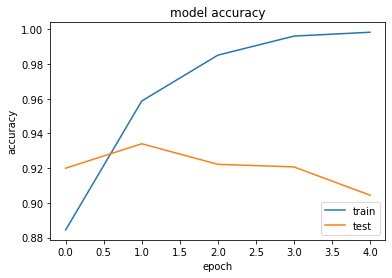

              precision    recall  f1-score   support

   Objective       0.85      0.96      0.90       477
  Subjective       0.96      0.84      0.90       523

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



In [ ]:
# Create the model to predict the subjectivity of sentence from the Stab and Gurevych argumentation mining dataset (2017).
# Split between test and train set.

target_names=['Objective','Subjective']

y_pred=[]
y_true=[]

X_train, X_test, Y_train, Y_test = train_test_split(X_sentences_sub_obj, Y_sub_obj, test_size=0.1, random_state=22)

model=train_BLSTM(X_train,Y_train)

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model.predict(X_test).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0]))
y_true+=Y_test.tolist()

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

## **Prediction**

In [ ]:
X = text_tokenizer.texts_to_sequences(D_sentence_list)
X = pad_sequences(X, maxlen=MAX_LEN_sub_obj, padding="pre")

In [ ]:
y_pred=[]

# Store the probabilities predicted.
y_pred_temp=model.predict(X).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0],5))

In [ ]:
len(y_pred)

44936

In [ ]:
f = open("subj_obj_Debater.txt", "a")
for prediction in y_pred:
  f.write("{}--".format(prediction))
f.close()

In [ ]:
# Read the file
scores_text=open("subj_obj_Debater.txt").read()

In [ ]:
subjectivity_scores=scores_text.split('--')

In [ ]:
len(subjectivity_scores)

44937

In [ ]:
subjectivity_scores[:10]

['0.00049',
 '0.98715',
 '0.98454',
 '0.99642',
 '0.99768',
 '0.05026',
 '0.00503',
 '2e-05',
 '1e-05',
 '0.00076']